In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [335]:
train = pd.read_csv('input/train.csv', parse_dates=['DateTime'])
test = pd.read_csv('input/test.csv',  parse_dates=['DateTime'])

In [337]:
train.shape

(26729, 10)

In [324]:
train.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [325]:
import re
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
sc = preprocessing.StandardScaler()
def convertToYears(age):
    if age == 999.0:
        return age
    num = int(re.search('\d+', age).group())
    unit = re.search('[A-Za-z]+', age).group()
    
    if 'year' in unit:
        return num
    if 'week' in unit:
        return num/52
    if 'month' in unit:
        return num/12
    if 'day' in unit:
        return num/365
    return num


def prepData(train, test):
    
    #Encode OutcomeType
    le.fit(train.OutcomeType.values)
    train.OutcomeType = le.transform(train.OutcomeType.values)
    
    allData = pd.concat([train, test])
    
    #Drop some columns for simplicity
    allData = allData.drop(['AnimalID', 'Name', 'DateTime', 'OutcomeSubtype'],axis=1)
    
    #Convert age to age in years
    allData['AgeuponOutcome'] = allData.AgeuponOutcome.fillna(999.0)
    allData['ageInYears'] = allData.AgeuponOutcome.apply(convertToYears)
    ageMean = allData[allData.ageInYears < 999.0].ageInYears.mean()
    allData.loc[allData['ageInYears'] == 999.0, 'ageInYears'] = ageMean
    allData['ageInYears'] = sc.fit_transform(allData.ageInYears.reshape(1,-1)).T
    allData = allData.drop('AgeuponOutcome', axis=1)
    
    #Get dummies
    dummies = pd.get_dummies(allData[['Breed', 'AnimalType', 'Color', 'SexuponOutcome']])
    allData = pd.concat([allData, dummies], axis=1)
    allData = allData.drop(['Breed', 'AnimalType', 'SexuponOutcome', 'Color'], axis=1)
       
    return (allData, le)

In [326]:
allData, le = prepData(train, test)

In [327]:
train = allData.iloc[:train.shape[0],:].drop('ID', axis=1)

In [328]:
test =  allData.iloc[train.shape[0]:,:].drop('OutcomeType', axis=1)

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

params = {
    'C':[.001, .01, 1, 10, 100]
}

lr = LogisticRegression()
gs = GridSearchCV(lr, params)
gs.fit(train.drop('OutcomeType', axis=1).values, train['OutcomeType'].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [330]:
gs.best_score_ 

0.60933817202289653

In [334]:
gs.best_params_

{'C': 1}

In [281]:
bestLr = gs.best_estimator_
bestLr.fit(train.drop('OutcomeType', axis=1).values, train['OutcomeType'].values)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [300]:
testIds = test.ID

In [301]:
predictions = bestLr.predict(test.drop('ID', axis=1))

In [302]:
predictions = list(map(int, predictions))
predictions_orig = le.inverse_transform(predictions)

In [303]:
predictions_orig

array(['Transfer', 'Adoption', 'Adoption', ..., 'Transfer', 'Adoption',
       'Transfer'], dtype=object)

In [304]:
np.unique(predictions_orig)

array(['Adoption', 'Return_to_owner', 'Transfer'], dtype=object)

In [305]:
prediction_df = pd.DataFrame({'prediction':predictions_orig})

In [306]:
prediction_df

,prediction
0,Transfer
1,Adoption
2,Adoption
3,Transfer
4,Adoption
5,Return_to_owner
6,Adoption
7,Adoption
8,Adoption
9,Adoption


In [315]:
dummies = pd.get_dummies(prediction_df.prediction)
dummies['Died'] = 0
dummies['Euthanasia'] = 0

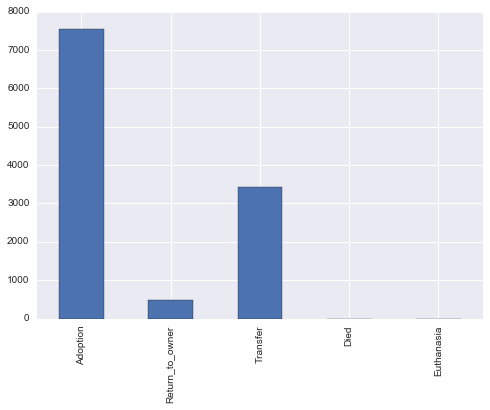

In [316]:
dummies.sum().plot(kind='bar')

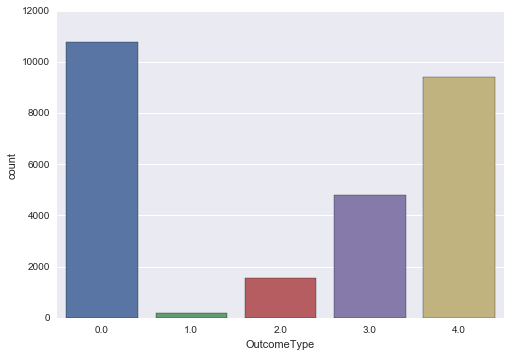

In [310]:
sns.countplot(train.OutcomeType)

In [317]:
dummies = pd.concat([testIds, dummies], axis=1) 

In [318]:
dummies =  dummies.applymap(int)

In [319]:
dummies.to_csv('lr3.csv',index =False)

12.47267